# Training

## About

This notebook contains the code to

- download the preprocessed dataset
- use trained `distilbert-base-uncased` tokenizer
- fine tune Classification model built on top of `distilbert-base-uncased`


## Imports

In [1]:
import pathlib
import sklearn
import datasets
import pandas as pd
import torch

import numpy as np
import transformers
import os
import plotly.figure_factory as ff
import wandb
from matplotlib import pyplot as plt


In [2]:
os.environ["WANDB_DISABLED"] = "false"

## Dataset

In [3]:
dataset_path = '../artifacts/dataset_processed/'

If the dataset was not prepared from the previous notebook, we can downaload the dataset checkpoint.

In [4]:
# %%bash
# cd ./artifacts/
# wget https://github.com/npatta01/pytorch-serving-workshop/releases/download/v0.0.1/dataset_processed.zip
# tar -xvf dataset_processed.zip

In [5]:
raw_datasets = datasets.load_from_disk(dataset_path)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'item_name', 'label', 'brand', 'item_id', 'main_image_id', 'node'],
        num_rows: 72743
    })
    test: Dataset({
        features: ['text', 'item_name', 'label', 'brand', 'item_id', 'main_image_id', 'node'],
        num_rows: 24248
    })
    valid: Dataset({
        features: ['text', 'item_name', 'label', 'brand', 'item_id', 'main_image_id', 'node'],
        num_rows: 24248
    })
})

60% , 20% , 20% for training/test/validation

sample record in the data

In [6]:
raw_datasets['train'][0]

{'text': 'Amazon Brand - Solimo Designer Light Blue Flower Photography 3D Printed Hard Back Case Mobile Cover for Sony Xperia L1',
 'item_name': 'Amazon Brand - Solimo Designer Light Blue Flower Photography 3D Printed Hard Back Case Mobile Cover for Sony Xperia L1',
 'label': 2,
 'brand': 'Amazon Brand - Solimo',
 'item_id': 'B07THC7RSK',
 'main_image_id': '71PBcKpr8jL',
 'node': '/Categories/Mobiles & Accessories/Mobile Accessories/Cases & Covers/Back & Bumper Cases'}

ProductType is our label is Label Encoded. 

In [7]:
labels = raw_datasets['train'].features['label'].names
labels

['ACCESSORY',
 'BOOT',
 'CELLULAR_PHONE_CASE',
 'CHAIR',
 'EARRING',
 'FINEEARRING',
 'FINENECKLACEBRACELETANKLET',
 'FINERING',
 'GROCERY',
 'HANDBAG',
 'HARDWARE_HANDLE',
 'HAT',
 'HEALTH_PERSONAL_CARE',
 'HOME',
 'HOME_BED_AND_BATH',
 'HOME_FURNITURE_AND_DECOR',
 'JANITORIAL_SUPPLY',
 'KITCHEN',
 'LAMP',
 'LIGHT_BULB',
 'LIGHT_FIXTURE',
 'OFFICE_PRODUCTS',
 'OUTDOOR_LIVING',
 'PET_SUPPLIES',
 'RUG',
 'SANDAL',
 'SHOES',
 'SOFA',
 'SPORTING_GOODS',
 'TABLE',
 'WALL_ART']

In [8]:
label2id = {}
for idx, label in enumerate(labels) : 
    label2id[label] = idx

In [9]:
base_model = "distilbert-base-uncased"

In [10]:
wandb.init(project="amazon_pt_classification", 
           name=base_model,
           group="bert")

wandb: Currently logged in as: npatta01 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Tokenizer

Load pretrained `distilbert-base-uncased` tokenizer form huggingface

In [11]:
tokenizer = transformers.AutoTokenizer.from_pretrained(base_model )

tokenize the `text` column in our dataset, truncating and padding 

In [12]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Loading cached processed dataset at ../artifacts/dataset_processed/train/cache-91dddd5c6693cb48.arrow
Loading cached processed dataset at ../artifacts/dataset_processed/test/cache-210e3b6a481560ef.arrow
Loading cached processed dataset at ../artifacts/dataset_processed/valid/cache-210e3b6a481560ef.arrow


In [13]:
subset = tokenized_datasets["train"].num_rows
# uncomment the below line to only train on subset
#subset = 2_000   


train_dataset = tokenized_datasets["train"].shuffle(seed=42)
valid_dataset = tokenized_datasets["valid"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)


# if we only want, less than 5_000 rows
if subset < 5_000:
    train_dataset = train_dataset.select(range(subset)) 
    valid_dataset = valid_dataset.select(range(subset)) 
    test_dataset = test_dataset.select(range(subset)) 

Loading cached shuffled indices for dataset at ../artifacts/dataset_processed/train/cache-ab74ad238ba10df3.arrow
Loading cached shuffled indices for dataset at ../artifacts/dataset_processed/valid/cache-57f900317716264e.arrow
Loading cached shuffled indices for dataset at ../artifacts/dataset_processed/test/cache-57f900317716264e.arrow


In [14]:
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

## Training 

use pretrained `distilbert-base-uncased` model as base for classification task

In [15]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(base_model
                                                                        , num_labels=len(labels)
                                                                       , label2id=label2id
                                                                       , id2label=id2label 
                                                                       )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

train for 5 epochs

In [16]:
training_args = transformers.TrainingArguments(f"trainer_{base_model}"
                                  , evaluation_strategy="epoch"
                                  , save_strategy="epoch"
                                  , logging_steps=100
                                 # , eval_steps=100
                                  , load_best_model_at_end=True
                                  ,num_train_epochs=5,              # total number of training epochs
                                               
                                  report_to="wandb",  # enable logging to W&B
                                               
                                 )

compute the below metrics per epoch `f1` ,`accuracy` , `precision` , `recall`

In [17]:
metric_f1 = datasets.load_metric('f1')
metric_accuracy = datasets.load_metric('accuracy')
metric_precision = datasets.load_metric('precision')
metric_recall = datasets.load_metric('recall')

In [18]:
def compute_metrics(eval_pred):
    metrics_dict = {}
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    metrics_dict.update(metric_f1.compute(predictions = predictions, references = labels, average = 'macro'))
    metrics_dict.update(metric_accuracy.compute(predictions = predictions, references = labels))
    metrics_dict.update(metric_precision.compute(predictions = predictions, references = labels, average = 'macro'))
    metrics_dict.update(metric_recall.compute(predictions = predictions, references = labels, average = 'macro'))
    return metrics_dict

In [19]:
trainer = transformers.Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)


In [20]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: brand, item_name, main_image_id, text, node, item_id.
***** Running training *****
  Num examples = 72743
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 11370
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/opt/conda/envs/pytorch/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.220600,0.193368,0.828716,0.937314,0.839927,0.827172
2,0.143900,0.161710,0.878744,0.952202,0.880289,0.880964
3,0.093800,0.161818,0.889904,0.956739,0.902305,0.880800
4,0.059100,0.167562,0.893829,0.959131,0.897912,0.891549
5,0.033600,0.179393,0.900268,0.960698,0.902669,0.898780


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: brand, item_name, main_image_id, text, node, item_id.
***** Running Evaluation *****
  Num examples = 24248
  Batch size = 32
Saving model checkpoint to trainer_distilbert-base-uncased/checkpoint-2274
Configuration saved in trainer_distilbert-base-uncased/checkpoint-2274/config.json
Model weights saved in trainer_distilbert-base-uncased/checkpoint-2274/pytorch_model.bin
/opt/conda/envs/pytorch/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: brand, item_name, main_image_id, te

TrainOutput(global_step=11370, training_loss=0.14194499899026272, metrics={'train_runtime': 6624.8884, 'train_samples_per_second': 54.901, 'train_steps_per_second': 1.716, 'total_flos': 4.820529753380352e+16, 'train_loss': 0.14194499899026272, 'epoch': 5.0})

Based on the training loss, it looks like the model is overfitting after 4 epochs

evaluate model on validation data

In [21]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: brand, item_name, main_image_id, text, node, item_id.
***** Running Evaluation *****
  Num examples = 24248
  Batch size = 32
/opt/conda/envs/pytorch/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.1617104858160019,
 'eval_f1': 0.8787441306932703,
 'eval_accuracy': 0.9522022434839987,
 'eval_precision': 0.8802892843330817,
 'eval_recall': 0.8809642823438425,
 'eval_runtime': 150.0274,
 'eval_samples_per_second': 161.624,
 'eval_steps_per_second': 5.052,
 'epoch': 5.0}

In [22]:
raw_predictions, raw_label_ids, raw_metrics = trainer.predict(test_dataset) 
y_pred = np.argmax(raw_predictions, axis=1)
y_true = test_dataset["label"]


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: brand, item_name, main_image_id, text, node, item_id.
***** Running Prediction *****
  Num examples = 24248
  Batch size = 32
/opt/conda/envs/pytorch/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [26]:
cm_labels

['ACCESSORY',
 'BOOT',
 'CELLULAR_PHONE_CASE',
 'CHAIR',
 'EARRING',
 'FINEEARRING',
 'FINENECKLACEBRACELETANKLET',
 'FINERING',
 'GROCERY',
 'HANDBAG',
 'HARDWARE_HANDLE',
 'HAT',
 'HEALTH_PERSONAL_CARE',
 'HOME',
 'HOME_BED_AND_BATH',
 'HOME_FURNITURE_AND_DECOR',
 'JANITORIAL_SUPPLY',
 'KITCHEN',
 'LAMP',
 'LIGHT_BULB',
 'LIGHT_FIXTURE',
 'OFFICE_PRODUCTS',
 'OUTDOOR_LIVING',
 'PET_SUPPLIES',
 'RUG',
 'SANDAL',
 'SHOES',
 'SOFA',
 'SPORTING_GOODS',
 'TABLE',
 'WALL_ART']

In [ ]:
test_dataset.

In [38]:
cm = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred = y_pred)
cm_labels = labels
fig = ff.create_annotated_heatmap(cm[::-1],colorscale='reds',
                                      xtype='array',
                                      ytype='array',
                                      x=cm_labels,
                                      #x=cm_labels[::-1],
                                      #y=cm_labels[::-1],
                                      y=cm_labels[::-1],
            showscale=True,
            hoverongaps=True,
                                 )

for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 8

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
   
)


fig.show()

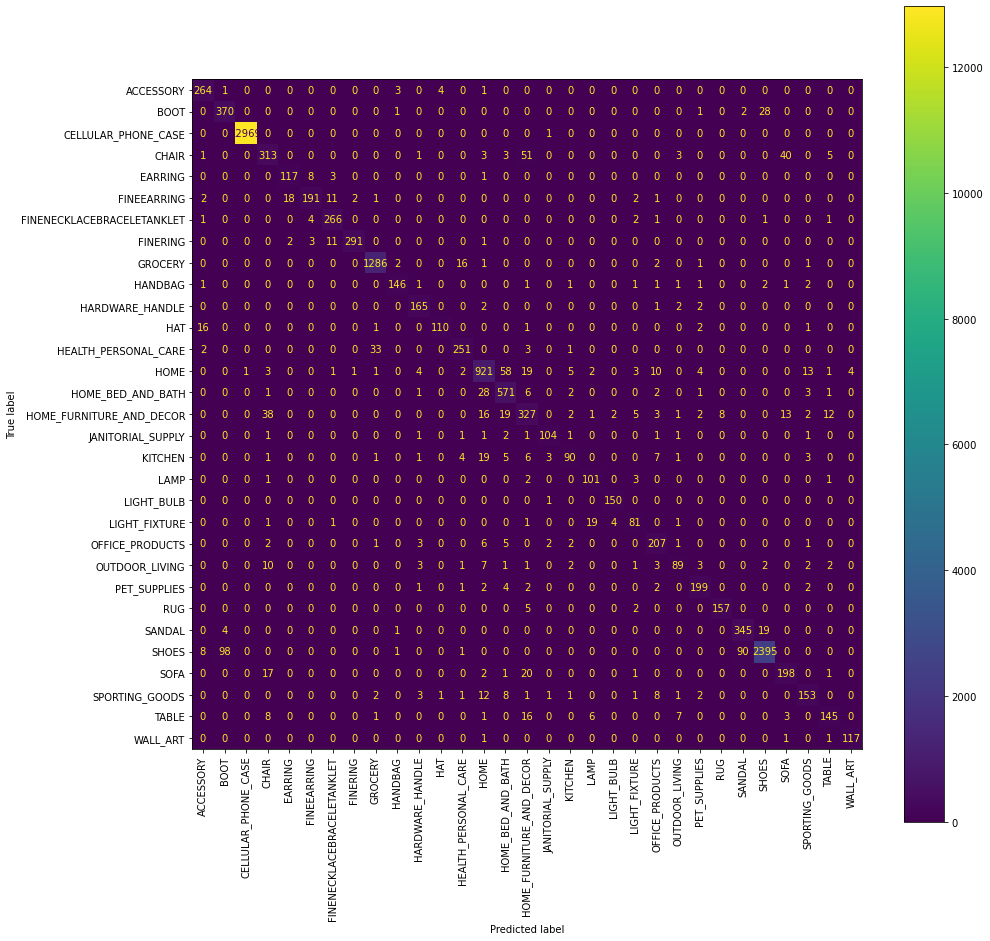

In [31]:
# https://stackoverflow.com/questions/60860121/plotly-how-to-make-an-annotated-confusion-matrix-using-a-heatmap
fig, ax = plt.subplots(figsize=(15,15))

disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=y_true, y_pred = y_pred ,
    #normalize = 'true',
    display_labels=cm_labels,
    xticks_rotation='vertical',
    ax=ax
)
disp

In [27]:
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                            preds=y_pred, y_true=y_true,
                            class_names=labels)})

In [ ]:
wandb.finish()

# Saving artifacts

In [39]:
model_dir = f'../artifacts/model/{base_model}/'

save the finetuned model

In [40]:
trainer.save_model(model_dir)

Saving model checkpoint to ../artifacts/model/distilbert-base-uncased/
Configuration saved in ../artifacts/model/distilbert-base-uncased/config.json
Model weights saved in ../artifacts/model/distilbert-base-uncased/pytorch_model.bin


save the tokenizer.    
Note: In this notebook , we didn't update the tokenizer

In [41]:
tokenizer.save_pretrained(model_dir)

tokenizer config file saved in ../artifacts/model/distilbert-base-uncased/tokenizer_config.json
Special tokens file saved in ../artifacts/model/distilbert-base-uncased/special_tokens_map.json


('../artifacts/model/distilbert-base-uncased/tokenizer_config.json',
 '../artifacts/model/distilbert-base-uncased/special_tokens_map.json',
 '../artifacts/model/distilbert-base-uncased/vocab.txt',
 '../artifacts/model/distilbert-base-uncased/added_tokens.json',
 '../artifacts/model/distilbert-base-uncased/tokenizer.json')

## Loading Artifacts

In [42]:
model2 = transformers.AutoModelForSequenceClassification.from_pretrained(model_dir, num_labels=len(labels))

loading configuration file ../artifacts/model/distilbert-base-uncased/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "ACCESSORY",
    "1": "BOOT",
    "2": "CELLULAR_PHONE_CASE",
    "3": "CHAIR",
    "4": "EARRING",
    "5": "FINEEARRING",
    "6": "FINENECKLACEBRACELETANKLET",
    "7": "FINERING",
    "8": "GROCERY",
    "9": "HANDBAG",
    "10": "HARDWARE_HANDLE",
    "11": "HAT",
    "12": "HEALTH_PERSONAL_CARE",
    "13": "HOME",
    "14": "HOME_BED_AND_BATH",
    "15": "HOME_FURNITURE_AND_DECOR",
    "16": "JANITORIAL_SUPPLY",
    "17": "KITCHEN",
    "18": "LAMP",
    "19": "LIGHT_BULB",
    "20": "LIGHT_FIXTURE",
    "21": "OFFICE_PRODUCTS",
    "22": "OUTDOOR_LIVING",
    "23": "PET_SUPPLIES",
    "24": "RUG",
    "25": "SANDAL",
    "26":

In [43]:
tokenizer2 = transformers.AutoTokenizer.from_pretrained(
                model_dir
            )

Didn't find file ../artifacts/model/distilbert-base-uncased/added_tokens.json. We won't load it.
loading file ../artifacts/model/distilbert-base-uncased/vocab.txt
loading file ../artifacts/model/distilbert-base-uncased/tokenizer.json
loading file None
loading file ../artifacts/model/distilbert-base-uncased/special_tokens_map.json
loading file ../artifacts/model/distilbert-base-uncased/tokenizer_config.json


# Predicting on new example

In [44]:
query = 'comfortable men sandals'

In [45]:
res = tokenizer2.encode_plus(query, return_tensors="pt",  padding="max_length", truncation=True)

In [46]:
res

{'input_ids': tensor([[  101,  6625,  2273, 24617,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

feed the input and attention mask to  model

In [47]:
model_res = model2(**res)
model_res

SequenceClassifierOutput(loss=None, logits=tensor([[-0.2216, -2.5249, -3.7834, -4.3393, -2.3555, -2.6455, -3.0635, -4.3248,
          0.9197, -2.8286, -5.5903, -2.0809,  0.5186, -4.3470, -3.0410, -2.2367,
         -4.4155, -3.9607, -5.0122, -4.8921, -4.6845, -3.6985, -2.6472, -1.8442,
         -2.1204,  5.2300,  0.2033, -4.5279,  0.2906, -3.1928, -3.5350]],
       grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

model_res[0] is the same as model_res.logits

In [48]:
model_res[0]

tensor([[-0.2216, -2.5249, -3.7834, -4.3393, -2.3555, -2.6455, -3.0635, -4.3248,
          0.9197, -2.8286, -5.5903, -2.0809,  0.5186, -4.3470, -3.0410, -2.2367,
         -4.4155, -3.9607, -5.0122, -4.8921, -4.6845, -3.6985, -2.6472, -1.8442,
         -2.1204,  5.2300,  0.2033, -4.5279,  0.2906, -3.1928, -3.5350]],
       grad_fn=<AddmmBackward>)

apply softmax and get top class and human label

In [49]:
predictions = list ( zip (labels , torch.softmax(model_res.logits, dim=1).tolist()[0] ) )
predictions = sorted (predictions , key=lambda x:x[1] , reverse =True)

In [50]:
predictions

[('SANDAL', 0.9552132487297058),
 ('GROCERY', 0.012827488593757153),
 ('HEALTH_PERSONAL_CARE', 0.008589162491261959),
 ('SPORTING_GOODS', 0.006838590372353792),
 ('SHOES', 0.00626652967184782),
 ('ACCESSORY', 0.004097452852874994),
 ('PET_SUPPLIES', 0.0008087287424132228),
 ('HAT', 0.0006382737192325294),
 ('RUG', 0.0006135497242212296),
 ('HOME_FURNITURE_AND_DECOR', 0.0005462064291350543),
 ('EARRING', 0.0004850088735111058),
 ('BOOT', 0.00040945346700027585),
 ('FINEEARRING', 0.00036292607546783984),
 ('OUTDOOR_LIVING', 0.0003622968797571957),
 ('HANDBAG', 0.0003022101882379502),
 ('HOME_BED_AND_BATH', 0.0002443601842969656),
 ('FINENECKLACEBRACELETANKLET', 0.00023893440084066242),
 ('TABLE', 0.0002099502889905125),
 ('WALL_ART', 0.0001491100701969117),
 ('OFFICE_PRODUCTS', 0.0001266185863642022),
 ('CELLULAR_PHONE_CASE', 0.00011631812958512455),
 ('KITCHEN', 9.741719259181991e-05),
 ('FINERING', 6.768658204236999e-05),
 ('CHAIR', 6.670993752777576e-05),
 ('HOME', 6.620392377953976e-

<a id='additional-resources'></a>

## Refernces

- [🤗 Transformers Examples](https://github.com/huggingface/transformers/tree/master/examples) which includes scripts
  to train on all common NLP tasks in PyTorch and TensorFlow.

